In [1]:
#Imports
import sys
sys.path.append('../../python/')
import NGC5533_functions as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp

from datetime import datetime

In [2]:
data = dp.getXYdata_wXYerr('../data/100kpc_data.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (list(a) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
v_err1 = np.asarray(v_err1)
#Express as weights
weighdata = 1/v_err1

In [3]:
#keeping others but holding them constant
def f(r,n,re,h,d_rho00):
     return np.sqrt(nf.bh_v(r,load=True,path='../')**2 
                    + nf.h_v(r,load=True,path='../')**2 
                    + nf.b_v(r,n,re,load=True,path='../')**2 
                    + nf.d_v(r,h,d_rho00,pref=False,load=True,path='../')**2)
#Only Bulge and Disk
def b_d(r,n,re,h,d_rho00):
    return np.sqrt(nf.b_v(r,n,re,load=True,path='../')**2 + nf.d_v(r,h,d_rho00,pref=False,load=True,path='../')**2)

In [4]:
#Fit, Keeping rest constant

#Setup
l_mod = lm.Model(f)
l_params = l_mod.make_params()
#Bulge Params
l_params.add('n', value=nf.n_c, min=0) 
l_params.add('re', value=nf.re_c, min=0) 
#Disk Params
l_params.add('h', value=nf.h_c, min=0, max=1000)
l_params.add('d_rho00', value=nf.drho00_c, min=0)
#Do fit
l_fit = l_mod.fit(v_dat,l_params,r=r_dat,weights=weighdata)

In [5]:
#Fit, B and D Only

#Setup
bd_mod = lm.Model(b_d)
bd_params = bd_mod.make_params()
#Bulge Params
bd_params.add('n', value=nf.n_c, min=0) 
bd_params.add('re', value=nf.re_c, min=0) 
#Disk Params
bd_params.add('h', value=nf.h_c, min=0, max=1000)
bd_params.add('d_rho00', value=nf.drho00_c, min=0)
#Do fit
bd_fit = bd_mod.fit(v_dat,bd_params,r=r_dat,weights=weighdata)

In [6]:
#Define curves to plot

l_dict = l_fit.best_values
l_n = l_dict['n']
l_re = l_dict['re']
l_h = l_dict['h']
l_d_rho00 = l_dict['d_rho00']
l_curve = f(r_dat,l_n,l_re,l_h,l_d_rho00)

bd_dict = bd_fit.best_values
bd_n = bd_dict['n']
bd_re = bd_dict['re']
bd_h = bd_dict['h']
bd_d_rho00 = bd_dict['d_rho00']

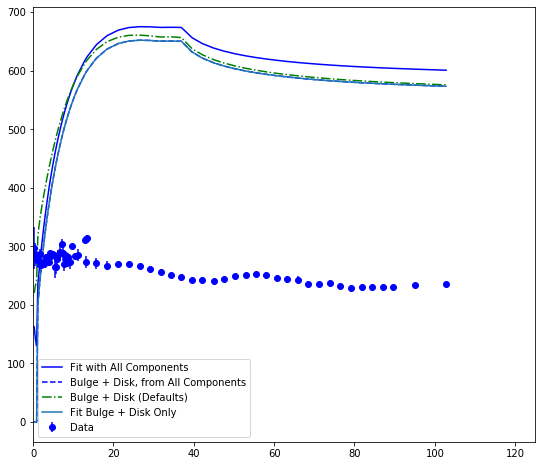

Fit information for all-component fit:


In [7]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,125)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='Fit with All Components')
plt.plot(r_dat,b_d(r_dat,l_n,l_re,l_h,l_d_rho00),'b--',label='Bulge + Disk, from All Components')
plt.plot(r_dat,b_d(r_dat,nf.n_c,nf.re_c,nf.h_c,nf.drho00_c),'g-.',label='Bulge + Disk (Defaults)')
plt.plot(r_dat,b_d(r_dat,bd_n,bd_re,bd_h,bd_d_rho00),label='Fit Bulge + Disk Only')

plt.legend()
plt.show()

print('Fit information for all-component fit:')
l_fit

NameError: name 'b_n' is not defined

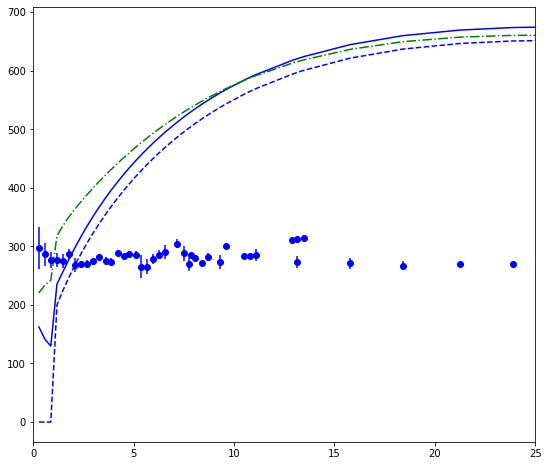

In [8]:
fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,l_curve,'b-',label='Fit with All Components')
plt.plot(r_dat,b_d(r_dat,l_n,l_re,l_h,l_d_rho00),'b--',label='Bulge + Disk, from All Components')
plt.plot(r_dat,b_d(r_dat,nf.n_c,nf.re_c,nf.h_c,nf.drho00_c),'g-.',label='Bulge + Disk (Defaults)')
plt.plot(r_dat,b_d(r_dat,b_n,b_re,b_h,b_d_rho00),label='Fit Bulge + Disk Only')

plt.legend()
plt.show()

print('Fit information for two-component fit')
bd_fit

In [ ]:
print('Timestamp:')
print(datetime.now())